# Inference and Capital Punishment

You will investigate the relationship between murder and capital punishment (the death penalty) in the United States.  By the end of the project, you should know how to:

1. Test whether observed data appears to be a random sample from a distribution
2. Analyze a natural experiment
3. Implement and interpret a sign test
4. Create a function to run a general hypothesis test
5. Analyze visualizations and draw conclusions from them

##### Due Date
The entire project (including both the first half and second half) will be due **Friday, December 9th at 11:59PM**. 

In [1]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

## 1. Murder rates
Punishment for crime has many [philosophical justifications](http://plato.stanford.edu/entries/punishment/#ThePun).  An important one is that fear of punishment may *deter* people from committing crimes.

In the United States, some jurisdictions execute some people who are convicted of particularly serious crimes, like murder.  This punishment is called the *death penalty* or *capital punishment*.  The death penalty is controversial, and deterrence has been one focal point of the debate.  There are other reasons to support or oppose the death penalty, but in this project we'll focus on deterrence.

The key question about deterrence is:

> Does instituting a death penalty for murder actually reduce the number of murders?

You might have a strong intuition in one direction, but the evidence turns out to be surprisingly complex.  Different sides have variously argued that the death penalty has no deterrent effect and that each execution prevents 8 murders, all using statistical arguments!  We'll try to come to our own conclusion.

Here is a road map for this project:

1. In the rest of this section, we'll investigate the main dataset we'll be using.
2. In section 2, we'll see how to test null hypotheses like this: "For this set of U.S. states, the murder rate was equally likely to go up or down each year."
3. In section 3, we'll apply a similar test to see whether U.S. states that suddenly ended or reinstituted the death penalty were more likely to see murder rates increase than decrease.
4. In section 4, we will run some more tests to further claims we had been developing in previous sections. 
5. In section 5, we'll try to answer our question about deterrence using a visualization rather than a formal hypothesis test.


#### The data
The main data source for this project comes from a [paper](http://cjlf.org/deathpenalty/DezRubShepDeterFinal.pdf) by three researchers, Dezhbakhsh, Rubin, and Shepherd.  The dataset contains rates of various violent crimes for every year 1960-2003 (44 years) in every US state.  The researchers compiled their data from the FBI's Uniform Crime Reports.

Since crimes are committed by people, not states, we need to account for the number of people in each state when we're looking at state-level data.  Murder rates are calculated as follows:

$$\text{murder rate for state X in year Y} = \frac{\text{number of murders in state X in year Y}}{\text{population in state X in year Y}}*100000$$

(Murder is rare, so we multiply by 100,000 just to avoid dealing with tiny numbers.)

In [2]:
murder_rates = Table.read_table('crime_rates.csv').select('State', 'Year', 'Population', 'Murder Rate')
murder_rates.set_format("Population", NumberFormatter)

State,Year,Population,Murder Rate
Alaska,1960,"226,167",10.2
Alaska,1961,"234,000",11.5
Alaska,1962,"246,000",4.5
Alaska,1963,"248,000",6.5
Alaska,1964,"250,000",10.4
Alaska,1965,"253,000",6.3
Alaska,1966,"272,000",12.9
Alaska,1967,"272,000",9.6
Alaska,1968,"277,000",10.5
Alaska,1969,"282,000",10.6


So far, this looks like a dataset that lends itself to an observational study.  In fact, these data aren't even enough to demonstrate an *association* between the existence of the death penalty in a state in a year and the murder rate in that state and year!

**Question 1.1.** What additional information will we need before we can check for that association?

How many people received the death penalty in a state in a year?

What states abolish the death penalty?

Murder rates vary over time, and different states exhibit different trends. The rates in some states change dramatically from year to year, while others are quite stable. Let's plot a couple, just to see the variety.

**Question 1.2.** Draw a line plot with years on the horizontal axis and murder rates on the 
vertical axis. Include two lines: one for Alaska murder rates and one for Minnesota murder rates. Create this plot using a single call, `ak_mn.plot('Year')`.

*Hint*: To create two lines, you will need create the table `ak_mn` with two columns of murder rates, in addition to a column of years. You can use `join` to create this table, which will have the following structure:

| Year | Murder rate in Alaska | Murder rate in Minnesota |
|------|-----------------------|--------------------------|
| 1960 | 10.2                  | 1.2                      |
| 1961 | 11.5                  | 1                        |
| 1962 | 4.5                   | 0.9                      |

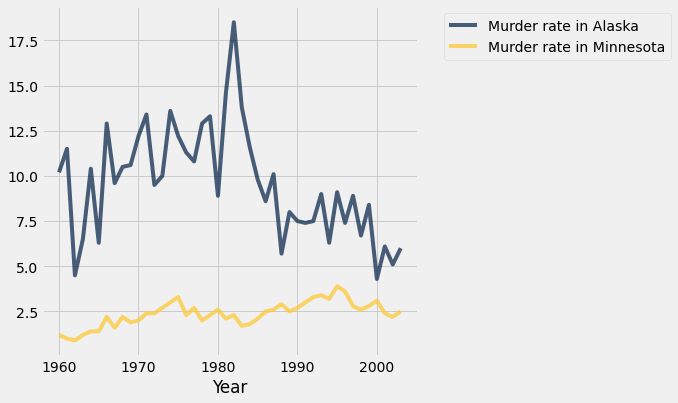

In [3]:
# The next lines are provided for you.  They create a table
# containing only the Alaska information and one containing
# only the Minnesota information.
ak = murder_rates.where('State', 'Alaska').drop('State', 'Population').relabeled(1, 'Murder rate in Alaska')
mn = murder_rates.where('State', 'Minnesota').drop('State', 'Population').relabeled(1, 'Murder rate in Minnesota')

# Fill in this line to make a table like the one pictured above.
ak_mn = ak.join('Year', mn)
ak_mn.plot('Year')

##### A reminder about tests
If you're not sure that your answer is correct, think about how you can check it.  For example, if a table has the right number of rows and columns, and a few randomly-selected values from each column are correct, then you can be somewhat confident you've computed it correctly.  For the previous question, try checking some of the values in `ak_mn` manually, by searching through the `murder_rates` table.

**Question 1.3.** Implement the function `most_murderous`, which takes a year (an integer) as its argument. It does two things:
1. It draws a horizontal bar chart of the 5 states that had the highest murder rate in that year.
2. It returns an array of the names of these states in order of *increasing* murder rate.

If the argument isn't a year in `murder_rates`, your function can do anything.

array(['California', 'Mississippi', 'Texas', 'New York', 'Louisiana'],
      dtype='<U14')

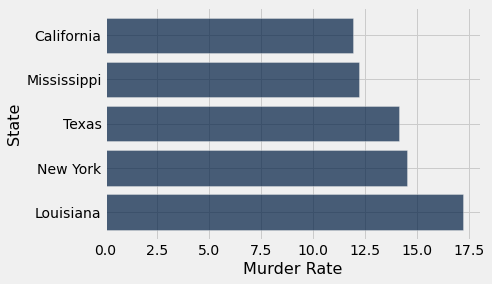

In [4]:
def most_murderous(year):
    # Fill in this line so that the next 2 lines do what the function
    # is supposed to do.  most should be a table.
    most = murder_rates.where('Year', year).sort('Murder Rate', descending=True).take(np.arange(5)).sort('Murder Rate')
    most.barh('State', 'Murder Rate')
    return most.column('State')

most_murderous(1990)

**Question 1.4.** How many more people were murdered in California in 1988 than in 1975? Assign `ca_change` to the answer.

*Hint*: Consider using the formula in the beginning of the section to answer this question. 

In [5]:
ca = murder_rates.where('State', are.equal_to('California'))
ca_murder_rate_1988 = ca.where('Year', 1988).first('Murder Rate')
ca_murder_rate_1975 = ca.where('Year', 1975).first('Murder Rate')
ca_population_1988 = ca.where('Year', 1988).first('Population')
ca_population_1975 = ca.where('Year', 1975).first('Population')
ca_change = ca_murder_rate_1988 / 100000 * ca_population_1988 - ca_murder_rate_1975 / 100000 * ca_population_1975
np.round(ca_change)

726.0

Certain mistakes would make your answer to the previous question way too small or way too big, and the automatic tests don't check that.  Make sure your answer looks reasonable after carefully reading the question.

# 2. Changes in Murder Rates

Murder rates vary widely across states and years, presumably due to the vast array of differences among states and across US history. Rather than attempting to analyze rates themselves, here we will restrict our analysis to whether or not murder rates increased or decreased over certain time spans. We will not concern ourselves with how much rates increased or decreased; only the direction of the change - *whether* they increased or decreased.

The `np.diff` function takes an array of values and computes the differences between adjacent items of a list or array. Instead, we may wish to compute the difference between items that are two positions apart. For example, given a 5-element array, we may want:

    [item 2 - item 0 , item 3 - item 1 , item 4 - item 2]
    
The `diff_n` function below computes this result. Don't worry if the implementation doesn't make sense to you, as long as you understand its behavior.

In [6]:
def diff_n(values, n):
    return np.array(values)[n:] - np.array(values)[:-n]

diff_n(make_array(1, 10, 100, 1000, 10000), 2)

array([  99,  990, 9900], dtype=int64)

**Question 2.1.** Implement the function `two_year_changes` that takes an array of murder rates for a state, ordered by increasing year. For all two-year periods (e.g., from 1960 to 1962), it computes and returns the number of increases minus the number of decreases.

For example, the rates `r = make_array(10, 7, 12, 9, 13, 9, 11)` contain three increases (10 to 12, 7 to 9, and 12 to 13), one decrease (13 to 11), and one change that is neither an increase or decrease (9 to 9). Therefore, `two_year_changes(r)` would return 2, the difference between three increases and 1 decrease.

In [7]:
def two_year_changes(rates):
    "Return the number of increases minus the number of decreases after two years."
    diff = diff_n(rates, 2)
    result = 0
    for i in diff:
        if i > 0:
            result += 1
        elif i < 0:
            result -= 1
        else:
            continue
    return result

print('Alaska:',    two_year_changes(ak.column('Murder rate in Alaska')))
print('Minnesota:', two_year_changes(mn.column('Murder rate in Minnesota')))

Alaska: -5
Minnesota: 6


We can use `two_year_changes` to summarize whether rates are mostly increasing or decreasing over time for some state or group of states. Let's see how it varies across the 50 US states.

**Question 2.2.** Assign `changes_by_state` to a table with one row per state that has two columns: the `State` name and the `Murder Rate two_year_changes` statistic computed across all years in our data set for that state.  Its first 2 rows should look like this:

|State|Murder Rate two_year_changes|
|-|-|
|Alabama|-6|
|Alaska|-5||


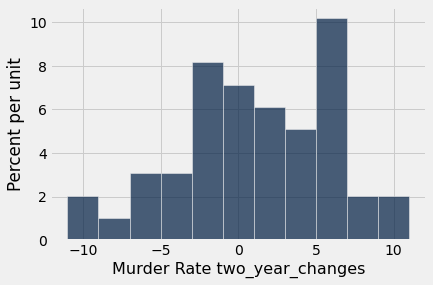

In [8]:
changes_by_state = murder_rates.drop('Year', 'Population').group('State', two_year_changes)

# Here is a histogram of the two-year changes for the states.
# Since there are 50 states, each state contributes 2% to one
# bar.
changes_by_state.hist('Murder Rate two_year_changes', bins=np.arange(-11, 12, 2))

Some states have more increases than decreases (a positive number), while some have more decreases than increases (a negative number). 

**Question 2.3.** Assign `total_changes` to the total increases minus the total decreases for all two-year periods and all states in our data set.

In [9]:
total_changes = sum(changes_by_state.column('Murder Rate two_year_changes'))
print('Total increases minus total decreases, across all states and years:', total_changes)

Total increases minus total decreases, across all states and years: 45


"More increases than decreases," one student exclaims, "Murder rates tend to go up across two-year periods. What dire times we live in."

"Not so fast," another student replies, "Even if murder rates just moved up and down uniformly at random, there would be some difference between the increases and decreases. There were a lot of states and a lot of years, so there were many chances for changes to happen. Perhaps this difference we observed is a typical value when so many changes are observed if the state murder rates increase and decrease at random!"

**Question 2.4.** Set `num_changes` to the number of different two-year periods in the entire data set that could result in a change of a state's murder rate. Include both those periods where a change occurred and the periods where a state's rate happened to stay the same.

For example, 1968 to 1970 of Alaska would count as one distinct two-year period. 

In [10]:
states = murder_rates.sort('State', distinct = True).column('State')
periods = make_array()
for i in np.arange(len(states)):
    state_murder_rate = murder_rates.where('State', states.item(i)).column('Murder Rate')
    periods = np.append(periods, len(diff_n(state_murder_rate, 2)))
num_changes = sum(periods)
num_changes

2100.0

We now have enough information to perform a hypothesis test.

> **Null Hypothesis**: State murder rates increase and decrease over two-year periods as if 
"increase" or "decrease" were sampled at random from a uniform distribution, like a fair coin flip.

Since it's possible that murder rates are more likely to go up or more likely to go down, our alternative hypothesis should contemplate either case:

> **Alternative Hypothesis**: State murder rates are *either* more likely or less likely to increase than decrease over two-year periods.

*Technical note*: These changes in murder rates are not random samples from any population. They describe all murders in all states over all recent years. However, we can imagine that history could have been different, and that the observed changes are the values observed in only one possible world: the one that happened to occur. In this sense, we can evaluate whether the observed "total increases minus total decreases" is consistent with a hypothesis that increases and decreases are drawn at random from a uniform distribution.

**Question 2.5** Given these null and alternative hypotheses, define a good test statistic.

**Important requirements for your test statistic:** Choose a test statistic for which large positive values are evidence in favor of the alternative hypothesis, and other values are evidence in favor of the null hypothesis.  Your test statistic should depend only on whether murder rates increased or decreased, not on the size of any change.

The test statistic should determine whether murder rates increase or decrease and not based on the period. Also, the test statistic should show that the large values fall in the 5% supporting the alternative hypothesis and other values should fall in the 95% supporting the null hypothesis.
Overall, the test statistic should be the number of increases minus the number of decreases.

The cell below samples increases and decreases at random from a uniform distribution 100 times. The final column of the resulting table gives the number of increases and decreases that resulted from sampling in this way.

In [11]:
uniform = Table().with_columns(
    "Change", make_array('Increase', 'Decrease'),
    "Chance", make_array(0.5,        0.5))
uniform.sample_from_distribution('Chance', 100)

Change,Chance,Chance sample
Increase,0.5,53
Decrease,0.5,47


**Question 2.6.** Complete the simulation below, which samples `num_changes` increases/decreases at random many times and forms an empirical distribution of your test statistic under the null hypothesis.  Your job is to
* fill in the function `simulate_under_null`, which simulates a single sample under the null hypothesis, and
* fill in its argument when it's called below.

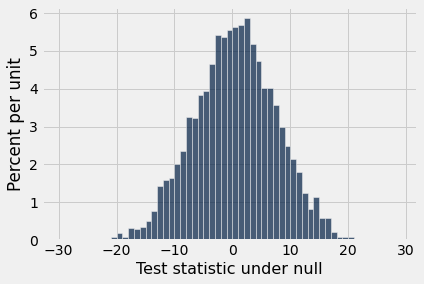

In [12]:
def simulate_under_null(num_chances_to_change):
    """Simulates some number changing several times, with an equal
    chance to increase or decrease.  Returns the value of your
    test statistic for these simulated changes.
    
    num_chances_to_change is the number of times the number changes.
    """
    return uniform.sample_from_distribution('Chance', 100).column('Chance sample').item(0) - uniform.sample_from_distribution('Chance', 100).column('Chance sample').item(1)

uniform_samples = make_array()
for i in np.arange(5000):
    uniform_samples = np.append(uniform_samples, simulate_under_null(num_changes))

# Feel free to change the bins if they don't make sense for your test statistic.    
Table().with_column('Test statistic under null', uniform_samples).hist(0, bins=np.arange(-30, 30))

**Question 2.7.** Looking at this histogram, draw a conclusion about whether murder rates basically increase as often as they decrease. (You *do not* need to compute a P-value for this question.)

From the histogram, we can see that the histogram is roughly uniformly distributed. The left side of the histogram represents the decrease in murder over the two-year period while the other side represents the increase of murder over the two-year period. Thus, the murder rates basically increase and decrease over two-year periods.

# 3. The death penalty

Some US states have the death penalty, and others don't, and laws have changed over time. In addition to changes in murder rates, we will also consider whether the death penalty was in force in each state and each year.

Using this information, we would like to investigate how the death penalty affects the murder rate of a state.

**Question 3.1.** Describe this investigation in terms of an experiment. What population are we studying? What is the control group? What is the treatment group? What outcome are we measuring?

*Write your answers below.*

- Population: ...
- Control Group: ...
- Treatment Group: ...
- Outcome: ...

**Question 3.2.** We want to know whether the death penalty *causes* a change in the murder rate.  Why is it not sufficient to compare murder rates in places and times when the death penalty was in force with places and times when it wasn't?

*Write your answer here, replacing this text.*

### A Natural Experiment

In order to attempt to investigate the causal relationship between the death penalty and murder rates, we're going to take advantage of a *natural experiment*.  A natural experiment happens when something other than experimental design applies a treatment to one group and not to another (control) group, and we can reasonably expect that the treatment and control groups don't have any other systematic differences.

Our natural experiment is this: in 1972, a Supreme Court decision called *Furman v. Georgia* banned the death penalty throughout the US.  Suddenly, many states went from having the death penalty to not having the death penalty.

As a first step, let's see how murder rates changed before and after the court decision.  We'll define the test as follows:

> **Population:** All the states that had the death penalty before the 1972 abolition.  (There is no control group for the states that already lacked the death penalty in 1972, so we must omit them.)  This includes all US states **except** Alaska, Hawaii, Maine, Michigan, Wisconsin, and Minnesota.

> **Treatment group:** The states in that population, in the year after 1972.

> **Control group:** The states in that population, in the year before 1972.

> **Null hypothesis:** Each state's murder rate was equally likely to be higher or lower in the treatment period than in the control period.  (Whether the murder rate increased or decreased in each state was like the flip of a fair coin.)

> **Alternative hypothesis:** The murder rate was more likely to increase *or* more likely to decrease.

*Technical Note:* It's not clear that the murder rates were a "sample" from any larger population.  Again, it's useful to imagine that our data could have come out differently and to test the null hypothesis that the murder rates were equally likely to move up or down.

The `death_penalty` table below describes whether each state allowed the death penalty in 1971.

In [13]:
non_death_penalty_states = make_array('Alaska', 'Hawaii', 'Maine', 'Michigan', 'Wisconsin', 'Minnesota')
def had_death_penalty_in_1971(state):
    """Returns True if the argument is the name of a state that had the death penalty in 1971."""
    # The implementation of this function uses a bit of syntax
    # we haven't seen before.  Just trust that it behaves as its
    # documentation claims.
    return state not in non_death_penalty_states

states = murder_rates.group('State').select('State')
death_penalty = states.with_column('Death Penalty', states.apply(had_death_penalty_in_1971, 0))
death_penalty

State,Death Penalty
Alabama,True
Alaska,False
Arizona,True
Arkansas,True
California,True
Colorado,True
Connecticut,True
Delaware,True
Florida,True
Georgia,True


In [14]:
num_death_penalty_states = death_penalty.where("Death Penalty", are.equal_to(True)).num_rows
num_death_penalty_states

44

**Question 3.3.** Assign `death_penalty_murder_rates` to a table with the same columns and data as `murder_rates`, but that has only the rows for states that had the death penalty in 1971.

The first 2 rows of your table should look like this:

|State|Year|Population|Murder Rate|
|-----|----|----------|-----------|
|Alabama|1960|3266740|12.4|
|Alabama|1961|3302000|12.9|

In [15]:
# The staff solution used 3 lines of code.
death_penalty_murder_rates = ...
death_penalty_murder_rates

Ellipsis

The null hypothesis doesn't specify *how* the murder rate changes; it only talks about increasing or decreasing.  So, we will use the same test statistic you defined in section 2.

**Question 3.4.** Assign `changes_72` to the value of the test statistic for the years 1971 to 1973 and the states in `death_penalty_murder_rates`.

*Hint:* You have already written nearly the same code in a previous part of this project.

In [16]:
# The staff solution took 5 lines of code.
test_stat_72 = ...

print('Increases minus decreases from 1971 to 1973:', test_stat_72)

Increases minus decreases from 1971 to 1973: Ellipsis


Look at the data (or perhaps a random sample!) to verify that your answer is correct.

**Question 3.5.**: Draw an empirical histogram of the statistic under the null hypothesis by simulating the test statistic 5,000 times.

*Hint:* In a previous part of this project, you have already written a function that runs such a simulation once.

TypeError: '<' not supported between instances of 'ellipsis' and 'float'

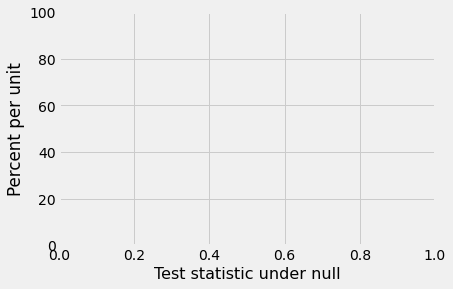

In [17]:
samples = make_array()
for i in np.arange(10000):
    samples = ...
# Feel free to change the bins if they don't make sense for your test statistic.
Table().with_column('Test statistic under null', samples).hist(bins=np.arange(-4, 28+2, 2))

### Conclusion
**Question 3.6.** Complete the analysis as follows:
1. Compute a P-value.
2. Draw a conclusion about the null and alternative hypotheses.
3. Describe your findings using simple, non-technical language.  Be careful not to claim that the statistical analysis has established more than it really has.

**P-value:** ...

**Conclusion about the hypotheses:** ...

**Findings:** ...

In [ ]:
# Use this cell to compute the P-value, if you wish.

# 4. Further evidence

So far, we have discovered evidence that when executions were outlawed, the murder rate increased in many more states than we would expect from random chance. We have also seen that across all states and all recent years, the murder rate goes up about as much as it goes down over two-year periods. 

These discoveries seem to support the claim that eliminating the death penalty increases the murder rate. Should we be convinced? Let's conduct some more tests to strengthen our claim.

Conducting a test for this data set required the following steps:

1. Select a table containing murder rates for certain states and all years,
2. Choose two years and compute the observed value of the test statistic,
3. Simulate the test statistic under the null hypothesis that increases and decreases are drawn uniformly at random, then
4. Compare the observed difference to the empirical distribution to compute a P-value.

This entire process can be expressed in a single function, called `run_test`.

**Question 4.1.** Implement `run_test`, which takes the following arguments:

- A table of murder `rates` for certain states, sorted by state and year like `murder_rates`, and
- the year when the analysis starts.  (The comparison group is two years later.)

It prints out the observed test statistic and returns the P-value for this statistic under the null hypothesis.

*Hint 1*: You can complete most of this question by copying code you wrote earlier. 

*Hint 2*: This problem might seem daumting.  Start by writing out the different steps involved in running a test.

In [ ]:
def run_test(rates, start_year):
    """Return a P-value for the observed difference between increases and decreases."""
    end_year = start_year + 2
    observed_test_statistic = ...
    print('Test statistic', start_year, 'to', end_year, ':', observed_test_statistic)
    num_states = rates.group('State').num_rows
    
    samples = make_array()
    for i in np.arange(5000):
        samples = ...
    ...

run_test(death_penalty_murder_rates, 1971)

### The rest of the states

We found a dramatic increase in murder rates for those states affected by the 1972 Supreme Court ruling, but what about the rest of the states? There were six states that had already outlawed execution at the time of the ruling.

**Question 4.2.** Create a table called `non_death_penalty_murder_rates` with the same columns as `murder_rates` but only containing rows for the six states without the death penalty in 1971. Perform the same test on this table. **Then**, in one sentence, conclude whether their murder rates were also more likely to increase from 1971 to 1973.

In [ ]:
non_death_penalty_murder_rates = ...
run_test(non_death_penalty_murder_rates, 1971)

*Write your answer here, replacing this text.*

### The death penalty reinstated

In 1976, the Supreme Court repealed its ban on the death penalty in its rulings on [a series of cases including Gregg v. Georgia](https://en.wikipedia.org/wiki/Gregg_v._Georgia), so the death penalty was reinstated where it was previously banned.  This generated a second natural experiment.  To the extent that the death penalty deters murder, reinstating it should decrease murder rates, just as banning it should increase them. Let's see what happened.

In [ ]:
print("Increases minus decreases from 1975 to 1977 (when the death penalty was reinstated) among death penalty states:",
      sum(death_penalty_murder_rates.where('Year', are.between_or_equal_to(1975, 1977))
                                    .group('State', two_year_changes)
                                    .column("Murder Rate two_year_changes")))
run_test(death_penalty_murder_rates, 1975)

*Hint:* To check your results, figure out what your test statistic should be when there are 18 more decreases than increases, and verify that that's the test statistic that was printed.  Also, you should have found a P-value near 0.01. If your P-value is very different, go back and inspect your `run_test` implementation and your test statistic to make sure that it correctly produces low P-values when there are many more decreases than increases.

**Question 4.3.** Now we've analyzed states where the death penalty went away and came back, as well as states where the death penalty was outlawed all along.  What do you conclude from  the results of the tests we have conducted so far? Does all the evidence consistently point toward one conclusion, or is there a contradiction?

*Write your answer here, replacing this text.*

## 5. Visualization

While our analysis appears to support the conclusion that the death penalty deters murder, [a 2006 Stanford Law Review paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf) argues the opposite: that historical murder rates do **not** provide evidence that the death penalty deters murderers.

To understand their argument, we will draw a picture.  In fact, we've gone at this whole analysis rather backward; typically we should draw a picture first and ask precise statistical questions later!

What plot should we draw?

We know that we want to compare murder rates of states with and without the death penalty.  We know we should focus on the period around the two natural experiments of 1972 and 1976, and we want to understand the evolution of murder rates over time for those groups of states.  It might be useful to look at other time periods, so let's plot them all for good measure.

**Question 5.1.** Create a table called `average_murder_rates` with 1 row for each year in `murder_rates`.  It should have 3 columns:
* `Year`, the year,
* `Death penalty states`, the average murder rate of the states that had the death penalty in 1971, and
* `No death penalty states`, the average murder rate of the other states.

`average_murder_rates` should be sorted in increasing order by year.  Its first three rows should look like:

|Year|Death penalty states|No death penalty states|
|-|-|-|
|1960| | |
|1961| | |
|1962| | ||

*Hint:*  Use `pivot`. To compute average murder rates across states, just average the murder rates; you do not need to account for differences in population.

In [ ]:
# For reference, our solution used 5 method calls
average_murder_rates = ...
average_murder_rates

**Question 5.2.** Describe in **one short sentence** a high-level takeaway from the line plot below. Are the murder rates in these two groups of states related?

In [ ]:
average_murder_rates.plot('Year')

*Write your answer here, replacing this text.*

Let's bring in another source of information: Canada.

In [ ]:
canada = Table.read_table('canada.csv')
murder_rates_with_canada = average_murder_rates.join("Year", canada.select("Year", "Homicide").relabeled("Homicide", "Canada"))
murder_rates_with_canada.plot('Year')

The line plot we generated above is similar to a figure from the [paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf).

<img src="paper_plot.png"/>

Canada has not executed a criminal since 1962. Since 1967, the only crime that can be punished by execution in Canada is the murder of on-duty law enforcement personnel. The paper states, "The most striking finding is that the homicide rate in Canada has moved in
virtual lockstep with the rate in the United States."

**Question 5.4.** Complete their argument in 2-3 sentences; what features of these plots indicate that the death penalty is not an important factor in determining the murder rate? (If you're stuck, read the [paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf).)

*Write your answer here, replacing this text.*

**Question 5.5.** What assumption(s) did we make in Parts 1 through 4 of the project that led us to believe that the death penalty deterred murder, when in fact the line plots tell a different story?

*Write your answer here, replacing this text.*

**You're done with the first part of the project! Congratulations.**